# Intro
This is a jupyter notebook for finding distant/unrelated pairs using features generated from the full Pfam-A.hmm instead of the two hmm files used in BiG-SLICE

This code is part of the BiG-SCAPE 2.0 thesis project  

Start by importing these modules

In [3]:
import multiprocessing
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import plots.hist

import data
import truth.truth as truth
import input.paths as paths
import input.bigslice_hmm

import predictions
import predictions.tests

import validation

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from scipy import spatial

import math

The following code instantiates any relevant paths to data or output. Make sure to change these for your purposes.
Not all the paths may be relevant, e.g. if you are using the bigscape_distances.tsv that is included in this repository.

In [4]:
# location of the full bigscape distances tab separated file.
# this file is created if you are loading new values from a run using the path after this one
FULL_TSV = "bigscape_distances_glocal.tsv"

# location of the sqlite database to analyze
# this database contained generated features from Pfam-A only
SQLITE_DB = "D:/Temp/benchmark-out/just-features-100/data.db"


Load the truth data and init some other variables:

In [5]:
print("Loading truth")
# load truth values
TRUTH_DISTANCES = truth.from_file(FULL_TSV)

TRUTH_PAIRS = validation.pairs_from_distances(TRUTH_DISTANCES)

print("Loading stored info from database")
DB = data.Database(SQLITE_DB)

BGC_IDS = data.get_bgc_ids(DB)
HMM_IDS = data.get_hmm_ids(DB)

BGC_ID_NAME_DICT = data.get_bgc_id_name_dict(DB)
BGC_NAME_ID_DICT = {name: id for id, name in BGC_ID_NAME_DICT.items()}
print("Done")
print(len(BGC_IDS), "BGCs in database")

Loading truth
Loading stored info from database
Done
2982 BGCs in database


Instantiate data frames for feature matrix:

In [6]:
print("Instantiating dataframes")
# instantiate dataframes
FEATURES = pd.DataFrame(
    np.zeros((len(BGC_IDS), len(HMM_IDS)), dtype=np.uint8),
    index=BGC_IDS,
    columns=HMM_IDS
)

# fetch feature values from db
BGC_HMM_FEATURES = data.get_features(DB)
for bgc_id, hmm_id, value in BGC_HMM_FEATURES:
    FEATURES.at[bgc_id, hmm_id] = value
print("Done")

Instantiating dataframes
Done


We will start again by calculating simple euclidean distances from these features:

In [7]:
EUCLIDEAN_DISTS = predictions.get_distances(FEATURES, BGC_ID_NAME_DICT, metric="euclidean")

Look at these distances by correlating them to the BiG-SCAPE distances

Generating distance/index dictionary


Text(0, 0.5, 'BiG-SCAPE distance')

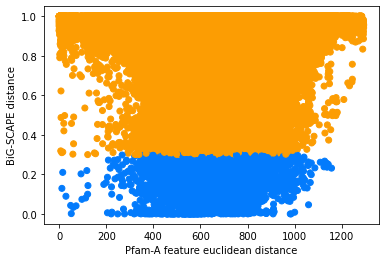

In [8]:
print("Generating distance/index dictionary")
EUCLID_DICT = {}
for bgc1, bgc2, dist in TRUTH_DISTANCES:
    pair_key = "-".join(sorted([bgc1, bgc2]))
    EUCLID_DICT[pair_key] = [dist]

for bgc1, bgc2, dist in EUCLIDEAN_DISTS:
    pair_key = "-".join(sorted([bgc1, bgc2]))
    # not all BGCs have features
    if pair_key not in EUCLID_DICT:
        continue
    # ignore duplicates
    if (len(EUCLID_DICT[pair_key]) == 1):
        EUCLID_DICT[pair_key].append(dist)

euclid_scatter_x = []
euclid_scatter_y = []
euclid_scatter_color = []
for i, item in EUCLID_DICT.items():
    # again, not all bgcs had features, but they may be present in the dict
    if len(item) == 1:
        continue
    dist, idx = item
    euclid_scatter_x.append(idx)
    euclid_scatter_y.append(dist)
    if dist < 0.3:
        euclid_scatter_color.append("#037bfc")
    else:
        euclid_scatter_color.append("#fc9d03")

plt.scatter(euclid_scatter_x, euclid_scatter_y, c=euclid_scatter_color)
plt.xlabel("Pfam-A feature euclidean distance")
plt.ylabel("BiG-SCAPE distance")

Looks pretty familiar to the correlation matrix we saw in the BiG-SLICE-like features.  

Generate histogram:

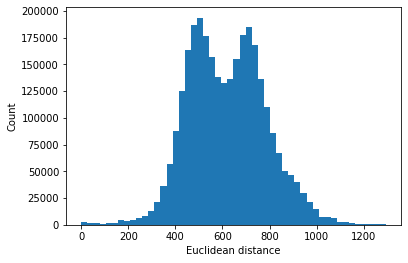

In [9]:
plots.hist.from_distances(EUCLIDEAN_DISTS, max=None, bins=50, xlab="Euclidean distance", ylab="Count")

I don't think we will be able to get anything from this based on our previous experience.  

We can try a different metric that is close to the cosine similarity but easier to calculate: L2 normalization with euclidean distance calculation:

In [10]:
FEATURES_NORM = pd.DataFrame(normalize(FEATURES, norm='l2', axis=0, copy=False, return_norm=False))

In [11]:
NORM_EUCLIDEAN_DISTS = predictions.get_distances(FEATURES_NORM, BGC_ID_NAME_DICT, metric="euclidean")

Look at the scatter again:

Generating distance/index dictionary


Text(0, 0.5, 'BiG-SCAPE distance')

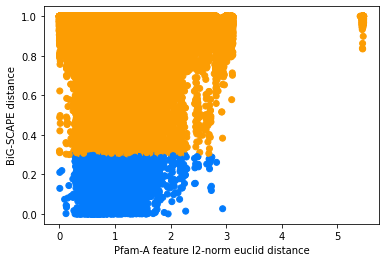

In [12]:
print("Generating distance/index dictionary")
NORM_EUCLID_DICT = {}
for bgc1, bgc2, dist in TRUTH_DISTANCES:
    pair_key = "-".join(sorted([bgc1, bgc2]))
    NORM_EUCLID_DICT[pair_key] = [dist]

for bgc1, bgc2, dist in NORM_EUCLIDEAN_DISTS:
    pair_key = "-".join(sorted([bgc1, bgc2]))
    # not all BGCs have features
    if pair_key not in NORM_EUCLID_DICT:
        continue
    # ignore duplicates
    if (len(NORM_EUCLID_DICT[pair_key]) == 1):
        NORM_EUCLID_DICT[pair_key].append(dist)

norm_euclid_scatter_x = []
norm_euclid_scatter_y = []
norm_euclid_scatter_color = []
for i, item in NORM_EUCLID_DICT.items():
    # again, not all bgcs had features, but they may be present in the dict
    if len(item) == 1:
        continue
    dist, idx = item
    norm_euclid_scatter_x.append(idx)
    norm_euclid_scatter_y.append(dist)
    if dist < 0.3:
        norm_euclid_scatter_color.append("#037bfc")
    else:
        norm_euclid_scatter_color.append("#fc9d03")

plt.scatter(norm_euclid_scatter_x, norm_euclid_scatter_y, c=norm_euclid_scatter_color)
plt.xlabel("Pfam-A feature l2-norm euclid distance")
plt.ylabel("BiG-SCAPE distance")

Not as different from the raw euclidean distances as we would like. Check distribution:

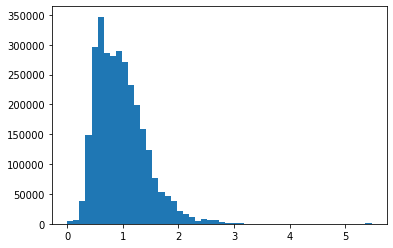

In [13]:
plots.hist.from_distances(NORM_EUCLIDEAN_DISTS, max=None, bins=50)

We won't bother with this one based on how this went last time. Collate all these images into one figure for the report:

Text(-0.15, 1.0, 'D')

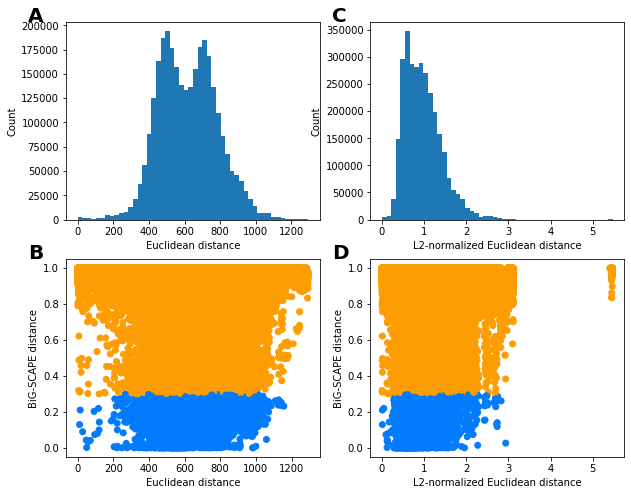

In [14]:
# get subplots
fig, axes = plt.subplots(2, 2)
# resize
fig.set_size_inches(10, 8)

euclid_freq_ax = axes[0, 0] # top left
euclid_scatter_ax = axes[1, 0] # bottom left
norm_euclid_freq_ax = axes[0, 1] # top right
norm_euclid_scatter_ax = axes[1, 1] # bottom right

# euclidean dist freq plot
euclid_dists = []
for idx, index_entry in enumerate(EUCLIDEAN_DISTS):
    if idx == max:
        break
    euclid_dists.append(index_entry[2])

euclid_freq_ax.hist(euclid_dists, bins=50)

euclid_freq_ax.set_xlabel("Euclidean distance")
euclid_freq_ax.set_ylabel("Count")
euclid_freq_ax.text(-0.15, 1.0, "A", transform=euclid_freq_ax.transAxes,
            size=20, weight='bold')


# euclidean dist scatter plot
euclid_scatter_ax.scatter(euclid_scatter_x, euclid_scatter_y, c=euclid_scatter_color)
euclid_scatter_ax.set_xlabel("Euclidean distance")
euclid_scatter_ax.set_ylabel("BiG-SCAPE distance")
euclid_scatter_ax.text(-0.15, 1.0, "B", transform=euclid_scatter_ax.transAxes,
            size=20, weight='bold')

# normalized euclidean dist freq plot
norm_euclid_dists = []
for idx, index_entry in enumerate(NORM_EUCLIDEAN_DISTS):
    if idx == max:
        break
    norm_euclid_dists.append(index_entry[2])

norm_euclid_freq_ax.hist(norm_euclid_dists, bins=50)

norm_euclid_freq_ax.set_xlabel("L2-normalized Euclidean distance")
norm_euclid_freq_ax.set_ylabel("Count")
norm_euclid_freq_ax.text(-0.15, 1.0, "C", transform=norm_euclid_freq_ax.transAxes,
            size=20, weight='bold')


# normalized euclidean dist scatter plot
norm_euclid_scatter_ax.scatter(norm_euclid_scatter_x, norm_euclid_scatter_y, c=norm_euclid_scatter_color)
norm_euclid_scatter_ax.set_xlabel("L2-normalized Euclidean distance")
norm_euclid_scatter_ax.set_ylabel("BiG-SCAPE distance")
norm_euclid_scatter_ax.text(-0.15, 1.0, "D", transform=norm_euclid_scatter_ax.transAxes,
            size=20, weight='bold')


Now let's have a look at the cosine distances again, starting with calculation:

In [15]:
COSINE_DISTS = []

cosine_similarities = cosine_similarity(FEATURES.sort_index(inplace=False))

for idx, dist_item in enumerate(TRUTH_DISTANCES):
    bgc_name_a, bgc_name_b, dist = dist_item
    bgc_id_a = BGC_NAME_ID_DICT[bgc_name_a]
    bgc_id_b = BGC_NAME_ID_DICT[bgc_name_b]
    dist = 1 - cosine_similarities[bgc_id_a - 1, bgc_id_b - 1]
    COSINE_DISTS.append([bgc_name_a, bgc_name_b, dist])


Then correlation plot:

Generating distance/index dictionary


Text(0, 0.5, 'BiG-SCAPE distance')

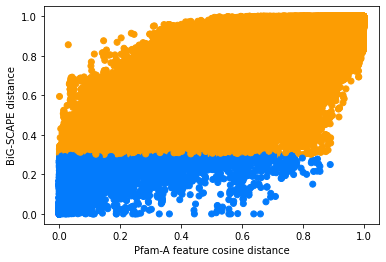

In [16]:
print("Generating distance/index dictionary")
COSINE_DICT = {}
for bgc1, bgc2, dist in TRUTH_DISTANCES:
    pair_key = "-".join(sorted([bgc1, bgc2]))
    COSINE_DICT[pair_key] = [dist]

for bgc1, bgc2, dist in COSINE_DISTS:
    pair_key = "-".join(sorted([bgc1, bgc2]))
    # not all BGCs have features
    if pair_key not in COSINE_DICT:
        continue
    # ignore duplicates
    if (len(COSINE_DICT[pair_key]) == 1):
        COSINE_DICT[pair_key].append(dist)

scatter_x = []
scatter_y = []
scatter_color = []
for i, item in COSINE_DICT.items():
    # again, not all bgcs had features, but they may be present in the dict
    if len(item) == 1:
        continue
    dist, idx = item
    scatter_x.append(idx)
    scatter_y.append(dist)
    if dist < 0.3:
        scatter_color.append("#037bfc")
    else:
        scatter_color.append("#fc9d03")

plt.scatter(scatter_x, scatter_y, c=scatter_color)
plt.xlabel("Pfam-A feature cosine distance")
plt.ylabel("BiG-SCAPE distance")

Looks like there are better areas here which are only >0.3 BiG-SCAPE distances. Let's look at the distribution:

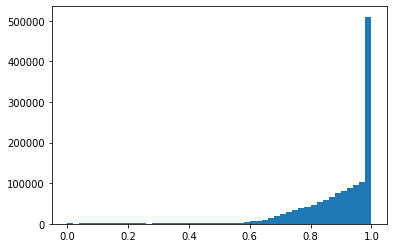

In [17]:
plots.hist.from_distances(COSINE_DISTS, max=None, bins=50)

Just like the jaccard and BiG-SLICE-like feature cosine distances, a majority of these pairs are at the extreme end(1.0)

In [18]:
results_upper = predictions.tests.distance.run_upper(
    COSINE_DISTS,
    TRUTH_PAIRS,
    upper_range=12,
    upper_cutoff_step=0.05,
    upper_cutoff_start=0.4
)

Predictions from distances (upper only):
cut_upp,under,over,unclass,prec,sens,spec,acc,ppv,npv,tp,fp,tn,fn
0.4,0,1326812,20835,NA,0.0,1.0,0.999,NA,0.999,0,0,1326102,747
0.45,0,1324483,23164,NA,0.0,1.0,1.0,NA,1.0,0,0,1323924,593
0.5,0,1321765,25882,NA,0.0,1.0,1.0,NA,1.0,0,0,1321293,504
0.55,0,1318000,29647,NA,0.0,1.0,1.0,NA,1.0,0,0,1317610,418
0.6,0,1311032,36615,NA,0.0,1.0,1.0,NA,1.0,0,0,1310780,278
0.65,0,1296253,51394,NA,0.0,1.0,1.0,NA,1.0,0,0,1296119,155
0.7,0,1263747,83900,NA,0.0,1.0,1.0,NA,1.0,0,0,1263662,98
0.75,0,1207491,140156,NA,0.0,1.0,1.0,NA,1.0,0,0,1207453,44
0.8,0,1127245,220402,NA,0.0,1.0,1.0,NA,1.0,0,0,1127231,14
0.85,0,1016525,331122,NA,0.0,1.0,1.0,NA,1.0,0,0,1016521,4
0.9,0,860855,486792,NA,NA,1.0,1.0,NA,1.0,0,0,860855,0
0.95,0,655705,691942,NA,NA,1.0,1.0,NA,1.0,0,0,655705,0


Some good results here. We can choose a cutoff of 0.7 where a vast majority of pairs are being excluded and we only exclude one pair incorrectly.  

Let's plot these for the report as well:

Text(-0.15, 1.0, 'D')

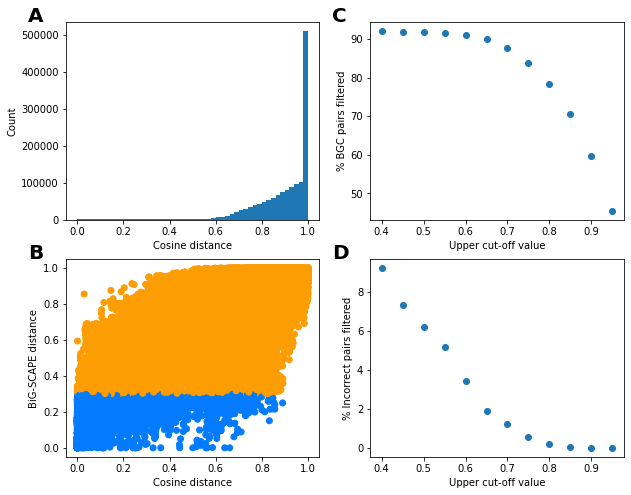

In [19]:
x_upper = []
y1_upper = []
y2_upper = []
# get results for lower cutoffs into arrays
for result_upper in results_upper:
    cutoff, tp, fp, tn, fn = result_upper
    # get % of total pairs filtered out
    perc_filtered = (tn+fn)/len(TRUTH_DISTANCES) * 100
    # get % of incorrectly filtered pairs
    perc_incorrect = fn/len(TRUTH_PAIRS[0]) * 100
    x_upper.append(cutoff)
    
    y1_upper.append(perc_filtered)
    y2_upper.append(perc_incorrect)

# get subplots
fig, axes = plt.subplots(2, 2)
# resize
fig.set_size_inches(10, 8)

freq_ax = axes[0, 0] # top left
scatter_ax = axes[1, 0] # bottom left
upper_filter_ax = axes[0, 1] # top right
upper_incorrect_ax = axes[1, 1] # bottom right

# freq plot
indices = []
for idx, index_entry in enumerate(COSINE_DISTS):
    if idx == max:
        break
    indices.append(index_entry[2])

freq_ax.hist(indices, bins=50)

freq_ax.set_xlabel("Cosine distance")
freq_ax.set_ylabel("Count")
freq_ax.text(-0.15, 1.0, "A", transform=freq_ax.transAxes,
            size=20, weight='bold')


# scatter plot
scatter_ax.scatter(scatter_x, scatter_y, c=scatter_color)
scatter_ax.set_xlabel("Cosine distance")
scatter_ax.set_ylabel("BiG-SCAPE distance")
scatter_ax.text(-0.15, 1.0, "B", transform=scatter_ax.transAxes,
            size=20, weight='bold')

# lower cutoff filtered stats
upper_filter_line = upper_filter_ax.scatter(x_upper, y1_upper)
upper_filter_ax.set_ylabel("% BGC pairs filtered")
upper_filter_ax.set_xlabel("Upper cut-off value")
upper_filter_ax.text(-0.15, 1.0, "C", transform=upper_filter_ax.transAxes,
            size=20, weight='bold')

# lower cutoff incorrect stats
upper_incorrect_line = upper_incorrect_ax.scatter(x_upper, y2_upper)
upper_incorrect_ax.set_ylabel("% Incorrect pairs filtered")
upper_incorrect_ax.set_xlabel("Upper cut-off value")
upper_incorrect_ax.text(-0.15, 1.0, "D", transform=upper_incorrect_ax.transAxes,
            size=20, weight='bold')